# This notebook creates a basic model to predict case postures

### Create TFIDF based model using sklearn multilearn
### Create basic explanation of class predictions using tfidf weight

Import basic packages

In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import re
import json

Import ML packages

In [2]:

from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss,classification_report

Install scikit multilearn for multi-label prediction model

In [3]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00


In [4]:
# Multi Label Pkgs
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

Mount google drive

In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Read text data in json

In [6]:
full_text=[]
for line in open('/content/drive/My Drive/TR_TechChallenge/TRDataChallenge2023.txt','r', encoding='utf-8', errors='replace'):
    full_text.append(json.loads(line))

Create pandas dataframe

In [7]:
full_text_pd = pd.json_normalize(full_text)

### Clean text - only take alphabets and text seperators

In [8]:
def cleanse_text(text):
    return re.sub(r'[^a-zA-Z,.\s]', '', text)

In [9]:
full_text_pd['sections'] = full_text_pd['sections'].apply(lambda x: cleanse_text(str(x)))

Calculate length of text sections

In [10]:
full_text_pd['len_of_sections'] = full_text_pd['sections'].apply(lambda x : len(x))

<Axes: xlabel='len_of_sections', ylabel='Count'>

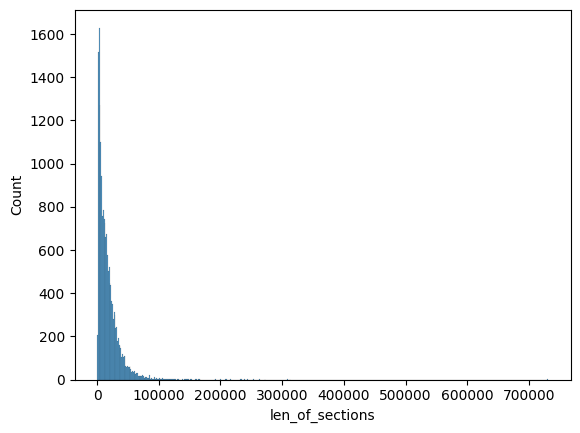

In [11]:
sns.histplot(full_text_pd['len_of_sections'])

Minimum and maximum length of texts

In [12]:
np.min(full_text_pd['len_of_sections'])

99

In [13]:
np.max(full_text_pd['len_of_sections'])

730675

# As the text size are smetimes too large - for the sake of MVP, limit the size to 5000

In [14]:
full_text_pd['sections_limited'] = full_text_pd['sections'].str[:5000]

Calculate number of postures for each case

In [15]:
full_text_pd['number_of_postures'] = full_text_pd['postures'].str.len()

In [16]:
full_text_pd.dtypes

documentId            object
postures              object
sections              object
len_of_sections        int64
sections_limited      object
number_of_postures     int64
dtype: object

Take cases which have at least one posture

In [17]:
train_df = full_text_pd[full_text_pd['number_of_postures']>0]

### Convert text in postures to class columns. Each class column will have binary 0 or 1 depending on if the posture is present or not (one hot encoding)

In [18]:
# Use pd.get_dummies() to one-hot encode the 'classes' column
train_df_expanded = train_df['postures'].str.join('|').str.get_dummies().add_prefix('class_')

# Concatenate the expanded columns with the original DataFrame
train_df_with_classes = pd.concat([train_df, train_df_expanded], axis=1)



# From the initial EDA notebook we identified only few postures appears at least in 2% of cases

### Hence we would only take those cases which are having those postures in outcome - in order to have a  MVP model

In [19]:
list_of_postures_to_take = ['class_On Appeal',
 'class_Appellate Review',
 'class_Review of Administrative Decision',
 'class_Motion to Dismiss',
 'class_Sentencing or Penalty Phase Motion or Objection',
 'class_Trial or Guilt Phase Motion or Objection',
 "class_Motion for Attorney's Fees",
 'class_Post-Trial Hearing Motion',
 'class_Motion for Preliminary Injunction',
 'class_Motion to Dismiss for Lack of Subject Matter Jurisdiction']

Create dataframe for selected classes and records which have at least one of the selected classes

In [20]:

### Other columns except classes
other_columns = [colname for colname in train_df_with_classes.columns if 'class_' not in colname]

### Selected most frequent classes
classes_selected = train_df_with_classes[list_of_postures_to_take]

### Create dataframe with only those classes
train_df_with_classes_selected = pd.concat([train_df_with_classes[other_columns],classes_selected], axis=1)

Identify the records which have at least one of the selected classes

In [21]:
### Count the sum of occurances for the selected classes
train_df_with_classes_selected['sum_of_selected_targets'] = train_df_with_classes_selected[list_of_postures_to_take].sum(axis=1)

In [22]:
### Take only those records which have count of selected classes > 0
train_df_with_selected_classes = train_df_with_classes_selected[train_df_with_classes_selected['sum_of_selected_targets']>0]

Define list of target classes from training dataset

In [23]:
target_list = [col_name for col_name in train_df_with_selected_classes.columns if  "class_" in col_name]

In [24]:
target_list

['class_On Appeal',
 'class_Appellate Review',
 'class_Review of Administrative Decision',
 'class_Motion to Dismiss',
 'class_Sentencing or Penalty Phase Motion or Objection',
 'class_Trial or Guilt Phase Motion or Objection',
 "class_Motion for Attorney's Fees",
 'class_Post-Trial Hearing Motion',
 'class_Motion for Preliminary Injunction',
 'class_Motion to Dismiss for Lack of Subject Matter Jurisdiction']

Install nltk package for data processing

In [25]:
!pip install nltk

Define nltk wordnet lemmatizer

In [43]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define function to lemmatize text

In [27]:
def lemmatize_model(text):
  lemmatizer = WordNetLemmatizer()
  lemma_text = text.split()
  lemmatize_list = []
  for word in lemma_text:
    lemmatize_list.append(lemmatizer.lemmatize(word,pos='v'))
  lemma_text_out =  " ".join([token for token in lemmatize_list])
  return lemma_text_out


Install neattext package for text cleansing

In [28]:
!pip install neattext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.9 MB/s eta 0:00:00


In [29]:
import neattext as nt
import neattext.functions as nfx

Apply text cleansing and lemmatizer
Create training text and targets

In [36]:
train_df_with_selected_classes['sections_limited'] = train_df_with_selected_classes['sections_limited'].apply(nfx.remove_stopwords)
train_df_with_selected_classes['sections_limited'] = train_df_with_selected_classes['sections_limited'].apply(nfx.remove_puncts)
train_df_with_selected_classes['sections_limited'] = train_df_with_selected_classes['sections_limited'].apply(lemmatize_model)

X = train_df_with_selected_classes['sections_limited']
y = train_df_with_selected_classes[target_list]


<ipython-input-36-4839cca66f8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_with_selected_classes['sections_limited'] = train_df_with_selected_classes['sections_limited'].apply(nfx.remove_stopwords)
<ipython-input-36-4839cca66f8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_with_selected_classes['sections_limited'] = train_df_with_selected_classes['sections_limited'].apply(nfx.remove_puncts)
<ipython-input-36-4839cca66f8f>:3: SettingWithCopyWarning: 
A value is trying to be set o

Create train test split

In [37]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


### The model will be trained using tfidf method. Hence would need to vectorize and then convert to tfidf

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In order to create tfidf - take the words which
  1. Appears at least 30 times in the whole corpus
  2. Does not appear in more than 20% of documents (to ensure we are not taking too common words

  Note - These bounds are purely based on assumption - no specific analysis is done at this level. May be further can fine tune these for real project

In [48]:
max_features_in = None
min_df_in = 30
max_df_in = 0.2

Create and fit vectorizer

In [49]:
vectorizer = CountVectorizer(max_features=max_features_in, min_df=min_df_in, max_df=max_df_in, stop_words=stopwords.words('english'))

In [50]:
vectorizer.fit(X_train)

CountVectorizer(max_df=0.2, min_df=30,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

Transform training samples using vectorizer

In [51]:
X_train_vectored = vectorizer.transform(X_train)


In [52]:
X_train_vectored.shape

(12912, 6703)

Transform testing samples using vectorizer

In [55]:
X_test_vectored = vectorizer.transform(X_test)

Fit and apply tfidf converter to training and testing data

In [56]:
tfidfconverter = TfidfTransformer()
tfidfconverter.fit(X_train_vectored)
X_train_tfidf = tfidfconverter.transform(X_train_vectored).toarray()
X_test_tfidf = tfidfconverter.transform(X_test_vectored).toarray()


In [57]:
X_train_tfidf.shape

(12912, 6703)

# Define binary classficiation using multinomial naive bayes

In [59]:


binary_rel_clf = BinaryRelevance(MultinomialNB())

In [60]:
import time

Fit the model and log the time taken

In [61]:
start_time = time.time()
binary_rel_clf.fit(X_train_tfidf,y_train)
end_time = time.time()



Run predictions on test data

In [62]:
br_prediction = binary_rel_clf.predict(X_test_tfidf)

In [63]:
X_test_tfidf.shape

(3228, 6703)

Calculate metrics
  - Accuracy and
  - Hamming loss

In [64]:
# Accuracy
acc = accuracy_score(y_test,br_prediction)

In [65]:
# hamming loss
hm_loss = hamming_loss(y_test,br_prediction)


train with words which are having : 
 30 entries at least 
 resulting in vectorizer size = 6703
 time taken =  14.909835577011108
 accuracy = 0.5442998760842627
 hamming loss = 0.06105947955390335


In [99]:
predictions_test = pd.DataFrame(br_prediction.toarray(),columns = y_test.columns)

In [115]:
# Create a new DataFrame with lists of columns containing 1s in each row
predictions_test_as_list = predictions_test.apply(lambda row: predictions_test.columns[row == 1].tolist(), axis=1)
y_test_as_list = y_test.apply(lambda row: y_test.columns[row == 1].tolist(), axis=1)



In [110]:
predictions_test_as_list

0                                       [class_On Appeal]
1                                       [class_On Appeal]
2                                       [class_On Appeal]
3       [class_On Appeal, class_Review of Administrati...
4       [class_Appellate Review, class_Trial or Guilt ...
                              ...                        
3223    [class_Appellate Review, class_Sentencing or P...
3224                                    [class_On Appeal]
3225                                    [class_On Appeal]
3226           [class_On Appeal, class_Motion to Dismiss]
3227    [class_Appellate Review, class_Sentencing or P...
Length: 3228, dtype: object

In [107]:
y_test_as_list.shape

(3228,)

In [130]:
test_actuals_vs_predictions = pd.DataFrame(list(zip(y_test_as_list,predictions_test_as_list)),columns=["actuals","predictions"])

In [131]:
from sklearn.metrics import jaccard_score

In [133]:
# Define a function to calculate Jaccard similarity
def calculate_jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    if len(set1) == 0 and len(set2) == 0:
        return 0  # Jaccard similarity is 0 for empty sets
    return len(set1.intersection(set2)) / len(set1.union(set2))

In [136]:
test_actuals_vs_predictions['jaccard_similarity'] = test_actuals_vs_predictions.apply(lambda row: calculate_jaccard_similarity(row['actuals'], row['predictions']), axis=1)

In [137]:
test_actuals_vs_predictions

,actuals,predictions,jaccard_similarity
0,[class_On Appeal],[class_On Appeal],1.0
1,[class_On Appeal],[class_On Appeal],1.0
2,"[class_On Appeal, class_Motion for Attorney's ...",[class_On Appeal],0.5
3,"[class_On Appeal, class_Review of Administrati...","[class_On Appeal, class_Review of Administrati...",1.0
4,"[class_Appellate Review, class_Trial or Guilt ...","[class_Appellate Review, class_Trial or Guilt ...",1.0
...,...,...,...
3223,[class_Sentencing or Penalty Phase Motion or O...,"[class_Appellate Review, class_Sentencing or P...",0.5
3224,[class_On Appeal],[class_On Appeal],1.0
3225,"[class_On Appeal, class_Motion for Attorney's ...",[class_On Appeal],0.5
3226,"[class_On Appeal, class_Motion to Dismiss]","[class_On Appeal, class_Motion to Dismiss]",1.0


In [139]:
avg_jaccard_similarity = np.mean(test_actuals_vs_predictions['jaccard_similarity'])

In [140]:
print("train with words which are having : \n "+str(min_df_in)\
      +" entries at least \n resulting in vectorizer size = "\
      +str(X_train_vectored.shape[1])+"\n time taken =  "\
      +str(end_time-start_time)+"\n accuracy = "+str(acc)\
      +"\n hamming loss = "+str(hm_loss)\
      +"\n average jaccard similarity ="+str(avg_jaccard_similarity))

train with words which are having : 
 30 entries at least 
 resulting in vectorizer size = 6703
 time taken =  14.909835577011108
 accuracy = 0.5442998760842627
 hamming loss = 0.06105947955390335
 average jaccard similarity =0.7076104915324246


Save model components
  - model
  - countvectorizer
  - tfidf converter

In [71]:
import joblib

In [72]:
path = '/content/drive/My Drive/TR_TechChallenge/'

In [73]:
# Save Model
binary_rel_clf_file = open(path+"binary_rel_clf_model_file.pkl","wb")
joblib.dump(binary_rel_clf,binary_rel_clf_file)
binary_rel_clf_file.close()

In [74]:
# Save vectorizer
binary_rel_vectorizer_file = open(path+"binary_rel_clf_vectorizer_file.pkl","wb")
joblib.dump(vectorizer,binary_rel_vectorizer_file)
binary_rel_vectorizer_file.close()

In [75]:
# Save tfidf
binary_rel_tfidf_file = open(path+"binary_rel_clf_tfidf_file.pkl","wb")
joblib.dump(tfidfconverter,binary_rel_tfidf_file)
binary_rel_tfidf_file.close()

# Explain Model

### In order to explain the model, we will take specific classes and calculate tfidf weights for the words for those specific classes

  Try to showcase that there are group of words who imparts maximum weights for different classes/postures

First create dataframe from tfidf vectors by having column names as words and values as tfidf values

In [76]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf,columns = vectorizer.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf,columns = vectorizer.get_feature_names_out())

In [77]:
X_train_tfidf_df.shape

(12912, 6703)

In [78]:
X_train_tfidf_df.head()

,aa,aaa,aaron,ab,abandon,abandonment,abate,abatement,abdomen,abet,...,younger,youngest,youre,youth,youve,zba,zbas,zero,zone,zoning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Define a function which will take the class name and feature data frame as inputs and will return a plot of top 20 important words for that class, along with a datafreme with those words and cumulative weights

In [80]:
def get_top_20_words_for_class(class_name,X_test_tfidf_df,y_test):
  """
  Function to return top 20 important words for a specific class/postures

  Input
  -----------
  class_name (string) : any one of the classes from the target postures
  X_test_tfidf_df (dataframe) : test records dataframe with columns as words and values as tfidf values
  y_test (dataframe) : target dataframe as binary hot-encoded classes in columns

  Output
  -----------
  Plot of top 20 words as per tfidf weights
  dataframe : dataframe with words and cumulative weights of them as per the tfidf values
  """

  ## Create a list of words from dataframes
  words_dict = X_test_tfidf_df.columns

  ### Create indices of records where the class was present in poustures
  pos_indices = [idx for idx,val in enumerate(y_test[class_name].values) if val ==1]

  ## Select the records for the indices
  X_test_spec_class = X_test_tfidf_df.iloc[pos_indices]

  ## Define empty bag of words
  bag_of_words = []

  ## Define empty list of weights
  weight_of_words = []

  ## For each row in the dataset selected
  for index, row in X_test_spec_class.iterrows():
    ## list of words where tfidf values is > 0
    text_loads = [words_dict[idx] for idx,val in enumerate(row.values.tolist()) if val > 0]
    ## list of the values
    weight_loads =  [row.values.tolist()[idx] for idx,val in enumerate(row.values.tolist()) if val > 0]
    ## append to bag of words as a list
    bag_of_words.append(text_loads)
    ## append to list of weights
    weight_of_words.append(weight_loads)

  ## At the end of loop

  ## flatten the bag of words
  bag_of_words_flattenned = [item for sublist in bag_of_words for item in sublist]
  ## flatten the list of weights
  weight_of_words_flattenned = [item for sublist in weight_of_words for item in sublist]

  ## Create dataframe with words and weights
  bag_of_words_df = pd.DataFrame(list(zip(bag_of_words_flattenned,weight_of_words_flattenned)),columns=['words_present','weights'])

  ## Calculate total weight for each word occurring in the cases and sort by descending total word weight
  bag_of_words_weights_grouped = bag_of_words_df.groupby('words_present')['weights'].sum().reset_index().sort_values('weights',ascending=False)
  ## Take top 20
  bag_of_words_weights_grouped_high = bag_of_words_weights_grouped.iloc[0:20,:]

  ## Plot the top 20 words with total weights
  sns.barplot(x='words_present', y='weights', data = bag_of_words_weights_grouped_high,palette=sns.color_palette('BrBG'))
  plt.xticks(rotation = 90)

  ## Return the dataframe with word weights
  return bag_of_words_weights_grouped_high

Analyse class = "On Appeal" (the most frequent posture)

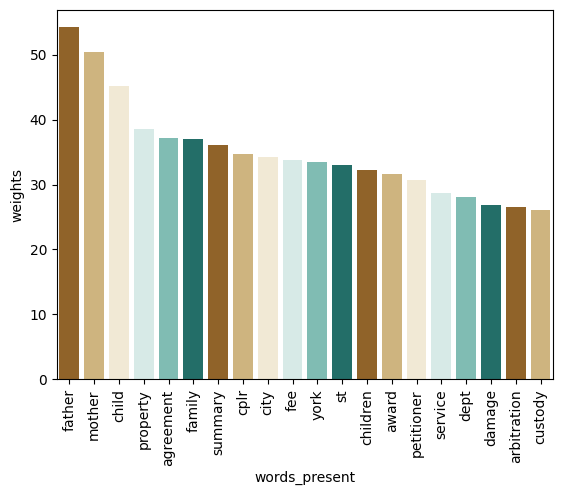

In [81]:
class_name = 'class_On Appeal'

top_20_words_weight_oa = get_top_20_words_for_class(class_name,X_test_tfidf_df,y_test)

Run the same for some other classes

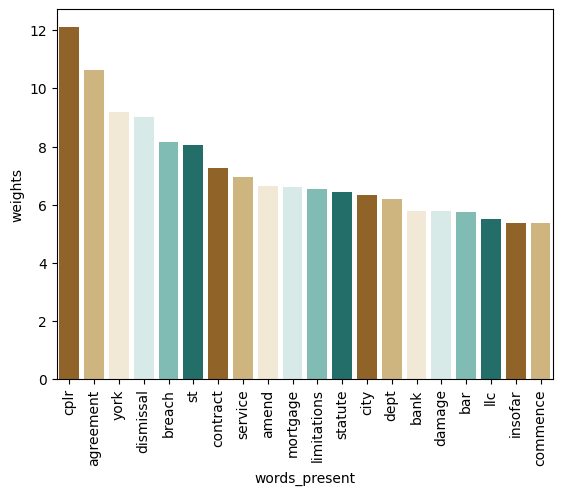

In [82]:
class_name = 'class_Motion to Dismiss'

top_20_words_weight_mtd = get_top_20_words_for_class(class_name,X_test_tfidf_df,y_test)

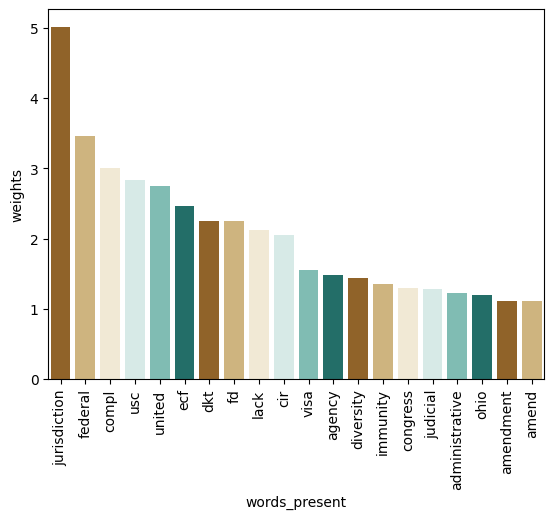

In [83]:
class_name = 'class_Motion to Dismiss for Lack of Subject Matter Jurisdiction'
top_20_words_weight_lsmj = get_top_20_words_for_class(class_name,X_test_tfidf_df,y_test)

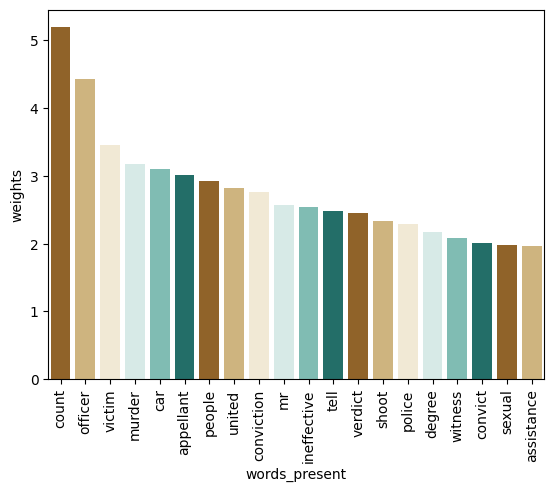

In [84]:
class_name = 'class_Post-Trial Hearing Motion'
top_20_words_weight_pthm = get_top_20_words_for_class(class_name,X_test_tfidf_df,y_test)

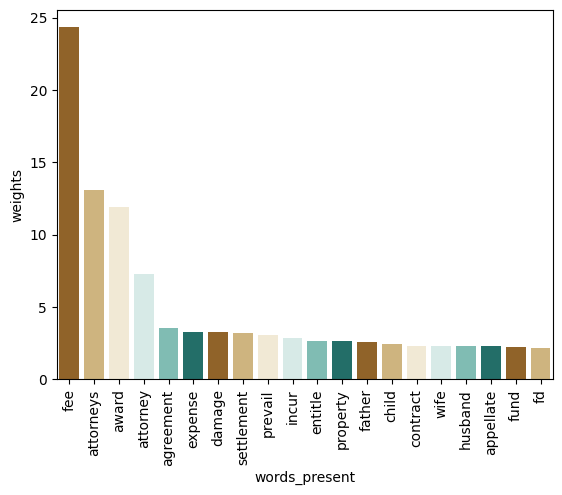

In [85]:
class_name = "class_Motion for Attorney's Fees"
top_20_words_weight_mfaf = get_top_20_words_for_class(class_name,X_test_tfidf_df,y_test)

In [86]:
mtd_words = top_20_words_weight_mtd['words_present'].values
att_fees_words = top_20_words_weight_mfaf['words_present'].values

In [87]:
mtd_words_over_att_fee_words =  [word for word in mtd_words if word not in att_fees_words ]
mtd_words_over_att_fee_words

['cplr',
 'york',
 'dismissal',
 'breach',
 'st',
 'service',
 'amend',
 'mortgage',
 'limitations',
 'statute',
 'city',
 'dept',
 'bank',
 'bar',
 'llc',
 'insofar',
 'commence']

In [88]:
att_fee_words_over_mtd_words = [word for word in att_fees_words  if word not in mtd_words ]
att_fee_words_over_mtd_words

['fee',
 'attorneys',
 'award',
 'attorney',
 'expense',
 'settlement',
 'prevail',
 'incur',
 'entitle',
 'property',
 'father',
 'child',
 'wife',
 'husband',
 'appellate',
 'fund',
 'fd']

In [89]:
common_words_att_fee_over_mtd_words = [word for word in att_fees_words  if word in mtd_words ]

In [90]:
common_words_att_fee_over_mtd_words

['agreement', 'damage', 'contract']